In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [277]:
from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.linalg as sl
import time

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

def fpStat(psr, f0):
    """
    Computes the Fp-statistic as defined in Ellis, Siemens, Creighton (2012)
    :param psr: List of pulsar object instances
    :param f0: Gravitational wave frequency
    :return: Value of the Fp statistic evaluated at f0
    """

    fstat=0.
    npsr = len(psr)

    # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
    N = np.zeros(2)
    # define M matrix M_ij=(A_i|A_j)
    M = np.zeros((2, 2))
    for ii,p in enumerate(psr):

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = 1./f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = 1./f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)

        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(p.invCov, p.residuals)), \
                      np.dot(A[1,:], np.dot(p.invCov, p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(p.invCov, A[kk,:]))
        
        # take inverse of M
        Minv = np.linalg.inv(M)
        fstat += 0.5 * np.dot(N, np.dot(Minv, N))

    # return F-statistic
    return fstat


def feStat(psr, gwtheta, gwphi, f0):
    """ 
    Computes the F-statistic as defined in Ellis, Siemens, Creighton (2012)   
    :param psr: List of pulsar object instances
    :param gwtheta: GW polar angle
    :param gwphi: GW azimuthal angle
    :param f0: Gravitational wave frequency
    :return: Value of the Fe statistic evaluated at gwtheta, phi, f0
    """
    
    npsr = len(psr)
    N = np.zeros(4)
    M = np.zeros((4,4))
    for ii, p in enumerate(psr):
        fplus, fcross, cosMu = createAntennaPatternFuncs(p, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(p.toas)))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)


        N += np.array([np.dot(A[0,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[1,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[2,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[3,:], np.dot(p.invCov, p.res))]) 

        M += np.dot(A, np.dot(p.invCov, A.T))

    # inverse of M
    Minv = np.linalg.pinv(M)

    # Fe-statistic
    return 0.5 * np.dot(N, np.dot(Minv, N))

In [345]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [373]:
datadir = enterprise.__path__[0] + '/datafiles/ng9/'

parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))
noisefiles = sorted(glob.glob(datadir + '/*noise.txt'))

In [348]:
#Trial with a few pulsars
parfile_J0030 = datadir + 'J0030+0451_NANOGrav_9yv1.gls.par'
parfile_B1937 = datadir + 'B1937+21_NANOGrav_9yv1.gls.par'


timfile_J0030 = datadir + 'J0030+0451_NANOGrav_9yv1.tim'
timfile_B1937 = datadir + 'B1937+21_NANOGrav_9yv1.tim'

noisefile_J0030 = datadir + 'J0030+0451_noise.txt'
noisefile_B1937 = datadir + 'B1937+21_noise.txt'

psr_J0030 = Pulsar(parfile_J0030,timfile_J0030)
psr_B1937 = Pulsar(parfile_B1937,timfile_B1937)

pulsars = [psr_J0030,psr_B1937]

In [376]:
#All of the Pulsars! Except J0218+4232 because it is naughty and doesn't have a noise file.
psrs = []

for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE421')
    if psr.name != 'J0218+4232':
        psrs.append(psr)

B1855+09
B1937+21
B1953+29
J0023+0923
J0030+0451
J0340+4130
J0613-0200
J0645+5158
J0931-1902
J1012+5307
J1024-0719
J1455-3330
J1600-3053
J1614-2230
J1640+2224
J1643-1224
J1713+0747
J1738+0333
J1741+1351
J1744-1134
J1747-4036
J1832-0836
J1853+1303
J1903+0327
J1909-3744
J1910+1256
J1918-0642
J1923+2515
J1944+0907
J1949+3106
J2010-1323
J2017+0603
J2043+1711
J2145-0750
J2214+3000
J2302+4442
J2317+1439


37


In [378]:
#Get parameter dict from noisefiles
params = {}
for nfile in noisefiles:
    params.update(get_noise_from_pal2(nfile))
#print(params)

In [379]:
##### parameters and priors #####
selection = Selection(selections.by_backend)

tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)


# white noise parameters
efac = parameter.Constant()
log10_equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
log10_A = parameter.LinearExp(-20,-12)
gamma = parameter.Uniform(0,7)

'''
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')
'''

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

'''
# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)
'''

# timing model
tm = gp_signals.TimingModel()

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=log10_equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# full model is sum of components
model = tm + ef + eq + ec + rn

# intialize PTA
pta_test = signal_base.PTA([model(pulsar) for pulsar in pulsars])
pta_full = signal_base.PTA([model(psr) for psr in psrs])

In [380]:
#Set Default PTA parameters to the ones in the noisefiles
pta_test.set_default_params(params)
pta_full.set_default_params(params)

INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.13871
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.917359
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.12336
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.14101
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_equad to -8.27762
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_equad to -5.94568
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_equad to -8.17663
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_log10_equad to -6.67303
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_ecorr to -7.6001
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_ecorr to -7.11084
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_ecorr to -7.59912
INFO: enterprise.signals.sig

INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_ASP_log10_ecorr to -7.03185
INFO: enterprise.signals.signal_base: Setting J0023+0923_L-wide_PUPPI_log10_ecorr to -7.79718
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.13871
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.917359
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.12336
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.14101
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_equad to -8.27762
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_equad to -5.94568
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_equad to -8.17663
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_log10_equad to -6.67303
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_ecorr to -7.6001
INFO: enterprise.signals.

INFO: enterprise.signals.signal_base: Setting J1600-3053_Rcvr_800_GASP_log10_ecorr to -7.42253
INFO: enterprise.signals.signal_base: Setting J1600-3053_Rcvr_800_GUPPI_log10_ecorr to -6.3244
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr1_2_GASP_efac to 1.15849
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr1_2_GUPPI_efac to 1.06146
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr_800_GASP_efac to 0.915636
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr_800_GUPPI_efac to 1.01366
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr1_2_GASP_log10_equad to -8.02865
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr1_2_GUPPI_log10_equad to -8.53141
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr_800_GASP_log10_equad to -8.01389
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr_800_GUPPI_log10_equad to -8.34908
INFO: enterprise.signals.signal_base: Setting J1614-2230_Rcvr1_2_GASP_log10_ecorr

INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GUPPI_log10_equad to -6.73425
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GASP_log10_equad to -6.47133
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_log10_equad to -6.5577
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GASP_log10_ecorr to -6.3269
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GUPPI_log10_ecorr to -6.45387
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GASP_log10_ecorr to -6.84423
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_log10_ecorr to -6.57852
INFO: enterprise.signals.signal_base: Setting J1747-4036_Rcvr1_2_GUPPI_efac to 1.13577
INFO: enterprise.signals.signal_base: Setting J1747-4036_Rcvr_800_GUPPI_efac to 1.10483
INFO: enterprise.signals.signal_base: Setting J1747-4036_Rcvr1_2_GUPPI_log10_equad to -7.85137
INFO: enterprise.signals.signal_base: Setting J1747-4036_Rcvr_800_

INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_efac to 1.09559
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_efac to 1.19833
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_efac to 1.39437
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_efac to 1.39417
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_log10_equad to -7.95891
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_log10_equad to -8.05202
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_log10_equad to -7.88786
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_PUPPI_log10_equad to -8.37225
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_ASP_log10_ecorr to -6.54216
INFO: enterprise.signals.signal_base: Setting J1944+0907_430_PUPPI_log10_ecorr to -7.20542
INFO: enterprise.signals.signal_base: Setting J1944+0907_L-wide_ASP_log10_ecorr to -6.06614
INFO: enterprise.signals.sig

INFO: enterprise.signals.signal_base: Setting J2317+1439_430_ASP_log10_equad to -6.92682
INFO: enterprise.signals.signal_base: Setting J2317+1439_430_PUPPI_log10_equad to -6.4171
INFO: enterprise.signals.signal_base: Setting J2317+1439_L-wide_PUPPI_log10_equad to -6.56296
INFO: enterprise.signals.signal_base: Setting J2317+1439_327_ASP_log10_ecorr to -7.59726
INFO: enterprise.signals.signal_base: Setting J2317+1439_327_PUPPI_log10_ecorr to -7.27493
INFO: enterprise.signals.signal_base: Setting J2317+1439_430_ASP_log10_ecorr to -6.14458
INFO: enterprise.signals.signal_base: Setting J2317+1439_430_PUPPI_log10_ecorr to -6.49356
INFO: enterprise.signals.signal_base: Setting J2317+1439_L-wide_PUPPI_log10_ecorr to -7.59813


########## FOR TESTING PURPOSES ONLY #################

fpstat = 0.0
f0 = 7e-8
#Internals of Fstat for test pta
TNrs = pta_test.get_TNr(xs_test)
TNTs = pta_test.get_TNT(xs_test)
phiinvs = pta_test.get_phiinv(xs_test, logdet=False, method='partition')
Nvecs = pta_test.get_ndiag(xs_test)
Ts = pta_test.get_basis(xs_test)
Nmat = []

for ii,p in enumerate(psrs):
    phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
    Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
    cf = sl.cho_factor(Sigma)      
    #Put pulsar's autoerrors in a diagonal matrix
    Ndiag = np.diag(1.0/Nvec)
    Tt = np.transpose(T)
    TtN = np.dot(Tt,Ndiag)
    expval2 = sl.cho_solve(cf,TtN)
    TtNt = np.transpose(TtN)
        
    #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
    Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
    # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
    N = np.zeros(2)
    # define M matrix M_ij=(A_i|A_j)
    M = np.zeros((2, 2))

    # Define A vector
    A = np.zeros((2, len(p.toas)))
    A[0,:] = f0**(-1./3.) * np.sin(2*f0*newtoas[ii])
    A[1,:] = f0**(-1./3.) * np.cos(2*f0*newtoas[ii])
    
    # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
    N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
    # define M matrix M_ij=(A_i|A_j)
    for jj in range(2):
        for kk in range(2):
            M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
    # take inverse of M
    Minv = sl.pinv(M)
        
    fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    

print(fpstat)

In [428]:
# make sure all pulsar have same reference time
tt=[] 
for p in psrs:
    tt.append(np.min(p.toas))

# find reference time
tref = np.min(tt)
newtoas = []
# now scale pulsar time
for p in psrs:
    newtoas.append((p.toas - tref))

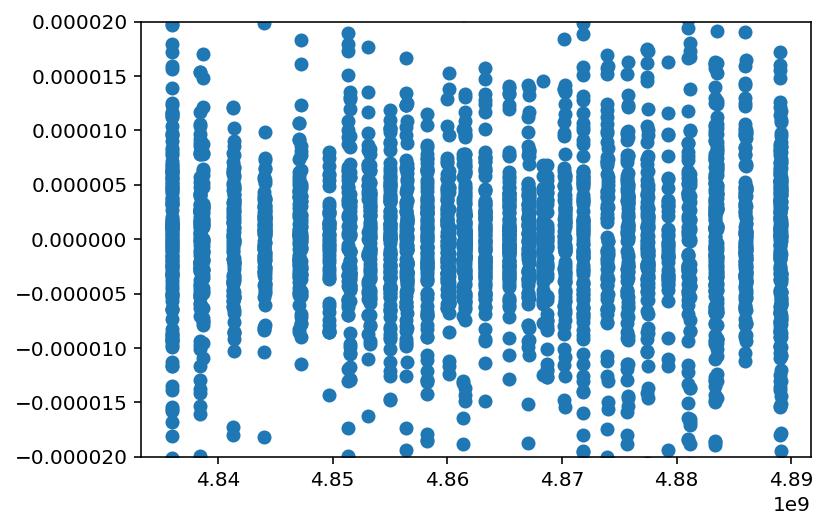

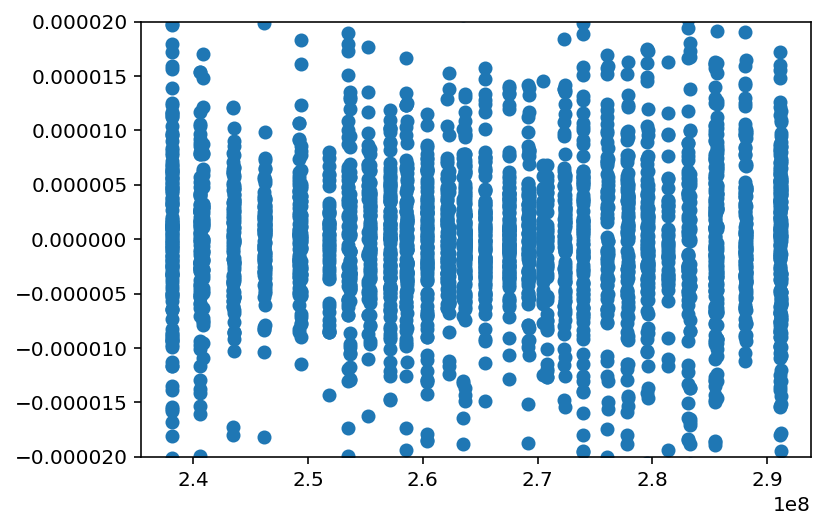

In [431]:
########## FOR TESTING PURPOSES ONLY #################
num = 5
plt.scatter(psrs[num].toas,psrs[num].residuals)
plt.ylim([-2e-5,2e-5])
plt.show()

plt.scatter(newtoas[num],psrs[num].residuals)
plt.ylim([-2e-5,2e-5])
plt.show()



In [338]:
########## TAKES FOREVER TO RUN, USE ANDREWFPSTAT2 AND GETNMATRIX #################
def AndrewFpstat(pta,psrs,params,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''

    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition')
    
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    
    Ts = pta.get_basis(params)
    Nmat = []
    
    # make sure all pulsar have same reference time
    #Unsure if necessary
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time and convert to seconds
    for p in psrs:
        newtoas.append((p.toas - tref))
    
    fpstat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        #Put pulsar's autoerrors in a diagonal matrix
        print(ii)
        TtN = Nvec.solve(other = np.eye(np.shape(p.residuals)[0]),left_array = T)
        Ndiag = Nvec.solve(other = np.eye(np.shape(p.residuals)[0]),left_array = np.eye(np.shape(p.residuals)[0]))
    
        expval2 = sl.cho_solve(cf,TtN)
        TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*newtoas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*newtoas[ii])
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return fpstat

In [440]:
def GenNmat(pta,params):
    '''Makes the Nmatrix used in the fstatistic'''
    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition') 
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    #Get the basis matrix
    Ts = pta.get_basis(params)
    Nmat = []
    print('Making Nmat')
    l1 = np.shape(TNrs)[0]
    i = 1
    
    for phiinv, TNr, TNT, Nvec, T in zip(phiinvs, TNrs, TNTs, Nvecs, Ts):
        start = time.time()
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        Nshape = np.shape(T)[0]
        TtN = Nvec.solve(other = np.eye(Nshape),left_array = T)
        
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = Nvec.solve(other = np.eye(Nshape),left_array = np.eye(Nshape))
    
        expval2 = sl.cho_solve(cf,TtN)
        #TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtN.T,expval2))
        end = time.time()
        print(repr(i) + ' out of ' + repr(l1) + ' Done. Time: ' + repr(end-start))
        i += 1
    return Nmat

In [ ]:
Nmat_test = GenNmat(pta_test,params)

Making Nmat
1 Done out of 2 Time: 6.1549272537231445


In [382]:
#Making and saving Nmatrix so it doesn't need to be calculated again
Nmatrix = GenNmat(pta_full,params)

['Making Nmat: ', 'Iteration ', 0, ' Time ', 23.263134956359863]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 337.13431310653687]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 0.8720319271087646]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 48.153566122055054]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 5.650280952453613]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 3.9512882232666016]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 147.6085307598114]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 4.060948848724365]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 0.11056709289550781]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 518.6332280635834]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 29.857935190200806]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 58.24466586112976]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 141.14121294021606]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 115.07314157485962]
['Making Nmat: ', 'Iteration ', 0, ' Time ', 7.505582809448242]
['Making Nmat: ', 'Iteration '

In [419]:
def AndrewFpstat2(psrs,Nmat,aligned_toas,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital angular frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    
    fpstat = 0.0
        
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(aligned_toas[ii])))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    return fpstat

In [422]:
f0 = 1/Tspan
print(AndrewFpstat2(psrs,Nmatrix,newtoas,f0))

3.421256282315104e-09
1953.3099046105165


In [335]:
print(AndrewFpstat(pta_test,pulsars,params,f0))
#print(pta_test.get_lnlikelihood(xs_test))

0
1
4.32658140139873


In [198]:
#print(AndrewFpstat(pta_full,psrs,f0))

5667.978525105191
1785173.9742654767


In [412]:
nfreqs = 1000
freqs = np.logspace(np.log10(1/Tspan),np.log10(3.3e-7),nfreqs)

i = 1
fstat_array = []
start = time.time()
for gwfreq in freqs:
    fstat_array.append(AndrewFpstat2(psrs,Nmatrix,newtoas,gwfreq))
    if i % 50 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

10 Done  Time Elapsed: 27.857797145843506
20 Done  Time Elapsed: 55.875099182128906
30 Done  Time Elapsed: 84.1232693195343
40 Done  Time Elapsed: 112.34764122962952
50 Done  Time Elapsed: 140.7729799747467
60 Done  Time Elapsed: 169.06674933433533
70 Done  Time Elapsed: 198.23237919807434
80 Done  Time Elapsed: 226.59270811080933
90 Done  Time Elapsed: 254.90127205848694
100 Done  Time Elapsed: 283.0926761627197
110 Done  Time Elapsed: 311.27030420303345
120 Done  Time Elapsed: 339.4322192668915
130 Done  Time Elapsed: 367.63125920295715
140 Done  Time Elapsed: 395.8784091472626
150 Done  Time Elapsed: 424.09803318977356
160 Done  Time Elapsed: 452.3413531780243
170 Done  Time Elapsed: 480.5031282901764
180 Done  Time Elapsed: 509.59359216690063
190 Done  Time Elapsed: 537.9932701587677
200 Done  Time Elapsed: 566.2028772830963
210 Done  Time Elapsed: 594.4416100978851
220 Done  Time Elapsed: 622.7147991657257
230 Done  Time Elapsed: 650.9388983249664
240 Done  Time Elapsed: 679.18812

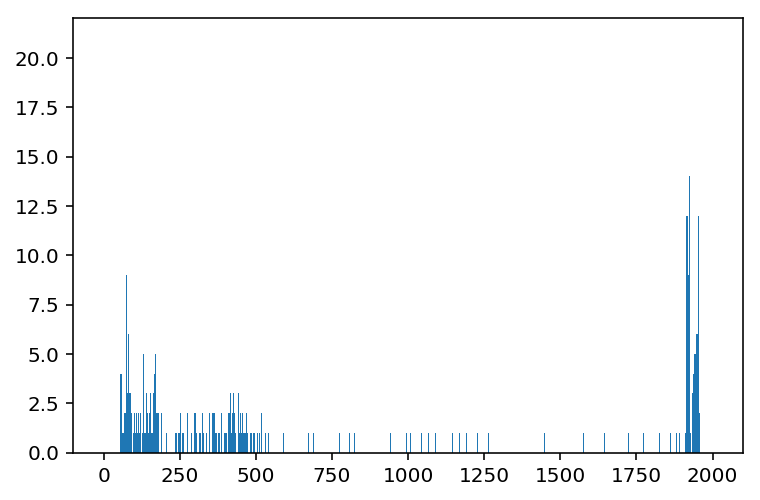

In [436]:
upper = 2000
lower = 0
pbins = range(2000)
plt.hist(2*fstat_array,bins = pbins,density = False)
plt.show()

In [200]:
########## TAKES FOREVER TO RUN, USE ANDREWFPSTAT2 AND GETNMATRIX #################
def AndrewFestat(pta,psrs,f0,gwphi,gwtheta):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    the orbital frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    params = pta.params #come up with a more clever way of doing this

    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition')
    
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    Ts = pta.get_basis(params)
    Nmat = []
    
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = np.diag(1.0/Nvec)
        Tt = np.transpose(T)
        TtN = np.dot(Tt,Ndiag)
        expval2 = sl.cho_solve(cf,TtN)
        TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(p.toas)))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*f0*p.toas)
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*f0*p.toas)
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*f0*p.toas)
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*f0*p.toas)


        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        M += np.dot(A, np.dot(p.invCov, np.transpose(A)))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [433]:
def AndrewFestat2(psrs,Nmat,aligned_toas,f0,gwphi,gwtheta):
    '''Takes in the pulsars that make up the pta, the Nmatrix from GetNmat 
    (Should make this a function in ptas to use self instead of pta?),
    the frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(aligned_toas[ii])))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])

        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        # define M matrix M_ij=(A_i|A_j)
        M += np.dot(A, np.dot(Nmat[ii], A.T))
        
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [435]:
gwtheta = 30/180*np.pi
gwphi = 10/180*np.pi
print(AndrewFestat2(psrs,Nmatrix,newtoas,f0,gwtheta,gwphi))

1951.473730308892
